# Detecting distribution changes in data streams

## Intro
Many real world problems involve time component, usually to monitor some phenomenon that can potentially change over time. This change could be for example a burst in network traffic, some abnormal video survelliance activity, an anomalous change in user's behaviour and many more.

One common concept of the situations mentioned above is the concept of **data stream**, a setting, in which data points are observed sequentially over time, rather than all at once.

## Task

In this data stream setting, we would like to have a model learn the dynamics of the current stream, and somehow be able to detect whether or not a change has occurred in the data generating distribution (i.e. underlying function or parameters change). 

More formally, suppose there's a random process $P$ that at each time step emits a value sampled from a probability distribution $\mathcal{P}(\bar{\theta}_1)$ where $\bar{\theta}_1$ is a set of parameters for the distribution. Suppose that at some point in time, $t'$ the process $P$ is subject to a change in the underlying data distribution to $\mathcal{D}(\bar{\theta}_2)$. Our task would be thus that of detecting the time of change $t'$ as quicky as possible.

**Example 1**

Suppose there is a random process that at each time step generates a value from a probability distribution $\mathcal{N}(\mu_1, \sigma_1)$.

Suppose we are observing one measurement $x_i$ at a time, thus, $x_1,x_2,....,x_{t'}$ a set of measurements up to a time step $t'$.

Now, if there random process whose values we are observing changes its distribution to $\mathcal{N}(\mu_2, \sigma_2)$, the values $x_{t'+1},...,x_{T}$ will follow the new distribution.

We want to promptly detect the moment $t'$.

## Approach

In this notebook we will present one possible approach to automatically detect such changes, that is based on martingale testing, defined in "A Martingale Framework for Detecting Changes in Data Streams by Testing Exchangeability".

In a nutshell, this algorithm keeps a set of points captured online, which are updated on arrival. A statistical test is used to estimate the likelihood of the new point to follow the distribution of the captured set of points. Once enough evidence is accumulated against the "all captured points belong to same distribution" hypothesis, a condition is triggered to detect the change in distribution.

### Building blocks of the algorithm

- **Strangeness function**: a function that given a set of points $T=\{x_1,...,x_n\}$ and a test point $x$, computes how much the data point $x$ is different from the other data points in the set $T$. One example of a strangeness function could is the clustering strangeness $f(T, x) = \left\lVert x - \text{centroid}(T) \right\rVert$.


- **Martingale**: intuitively, a martingale is a sequence of random variables that remains stable in value with some fluctuations as long as the process is random (at any particular time, the conditional expectation of the next value in the sequence is equal to the present value, regardless of all prior values).


- **Exchangeability property**: a sequence of random variables $Z_1, ..., Z_n$ is said to be exchangeable iff $P(Z_1, ..., Z_n) = P(Z_{\pi(1)}, ..., Z_{\pi(n)})$ where $\pi$ is a permutation function (the sequence is invariant under any permutation of its indices).


- **Exchangeability null hypothesis**: the algorithm operates under a null hypothesis $H_0$ that the date sequence is exchangeable (i.e. exchangeability property holds).

### Algorithm sketch

- A set of data points, called "current set" is used to store all the points that are being used for distribution shift detection, this set will be updated online.


- Once a new point is observed, its strangeness (we'll assume cluster model strangeness) with the data points in current set will be computed, measuring how different is this new point from the current set of points (the centroid they form).


- After each new data point is received, the algorithm computes the **randomized power martingale** value reflecting the strength of evidence found against the null hypothesis of data exchangeability.


- Randomized power martingale is defined as $M_n^{(\epsilon)} = \prod_{i=1}^n \epsilon\hat{p}_i^{\epsilon - 1}$ where $\hat{p}$ is called $\hat{p}$-value function.


- $\hat{p}$-value function is defined as $\hat{p}(\{x_1,...,x_i\}, \theta_i) = \frac{|\{j:s_j>s_i\}| + \theta_i|\{j:s_j=s_i\}|}{i}$ with $\theta_i \sim U(0, 1)$.


-  If points are generated from a source that satisfies exchangeability property (i.e. points are coming from the same distribution), then there's a property that $\hat{p}$-values will be distributed uniformly on $[0, 1]$. However, if this property is violated, then $\hat{p}$-values will no longer be distributed uniformly in $[0, 1]$ (due to strangeness of newer points being likely higher), as a result $M_n^{(\epsilon)}$ will increase, providing more evidence against null hypothesis $H_0$ of sequence exchangeability. The algorithm employs this property of $M_n^{(\epsilon)}$ to aid with detecting changes. 


- Martingale test continues to operate as long as $0 \lt M_n^{(\epsilon)} \lt \lambda$, and the null hypothesis $H_0$ is rejected when $M_n^{(\epsilon)} \geq \lambda$ namely "no change in data stream" hypothesis has a high evidence against it.


- The parameter $\lambda$ indicates a degree of false alarm rate (FAR) we are willing to accept from our detector.

## Outline

The remaining structure of the notebook is defined as follows:

1. **Imports**: all the imports used in this notebook.
2. **Synthetic example**: example of applying the detector on an easy synthetic dataset.
3. **Real world example**: example of applying the detector on a more complicated real-world dataset.

## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from detectors.martingale_tester import MartingaleTest, run_martingale_tester, martingale_tester_grid_search
from utils.cavitation_data import average_signal_columns, get_cavitation_features, load_cavitation_data
from utils.metrics import metrics_in_range
from utils.synthetic_data import generate_synthetic_normal
from utils.visualization import plot_total_df, plot_precision_recall_curve

## Synthetic example

In [2]:
# Define parameters of synthetic data
sizes_synthetic = [600, 500, 1050, 500]
means_synthetic = [0.34, 1.5, 2.9, 1.5]
std_synthetic = 0.8
changes_gt_synthetic = np.cumsum(sizes_synthetic)[:-1]
# Generate synthetic timeseries dataset
data_synthetic = generate_synthetic_normal(
    locs=means_synthetic, 
    sizes=sizes_synthetic, 
    scale=std_synthetic, dims=1
)
data_df_synthetic = pd.DataFrame(data_synthetic)

Let us plot the synthetically generated signal with changes of distribution highlighted by a different shade of red:

Changes in stream distribution occurred at:
	600
	1100
	2150


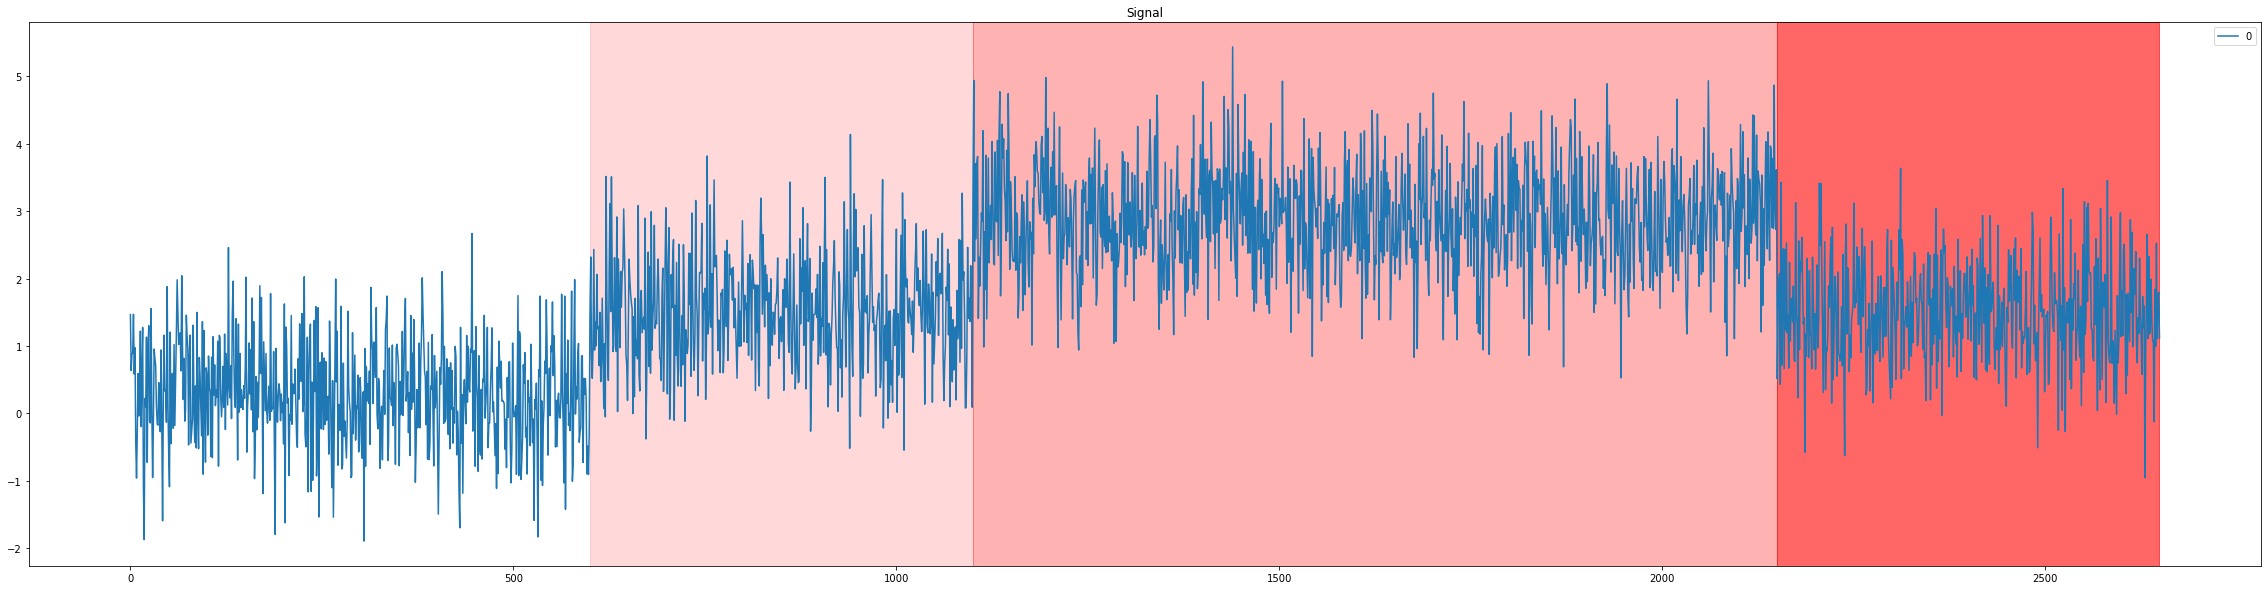

In [3]:
plot_total_df(
    data_df_synthetic, 
    "Signal", 
    changes=changes_gt_synthetic, 
    max_intensity=0.6
)

Let us run a Martingale Test algorithm described before on the synthetic dataset:

In [4]:
martingale_tester_synthetic = MartingaleTest(2, epsilon=0.96)
changes_pred_synthetic = run_martingale_tester(
    martingale_tester_synthetic,
    data_synthetic
)

In [5]:
metrics_in_range(gt=changes_gt_synthetic, pred=changes_pred_synthetic, interval=75)

{'precision': 1.0, 'recall': 1.0, 'F1': 1.0}

Changes in stream distribution occurred at:
	630
	1125
	2187


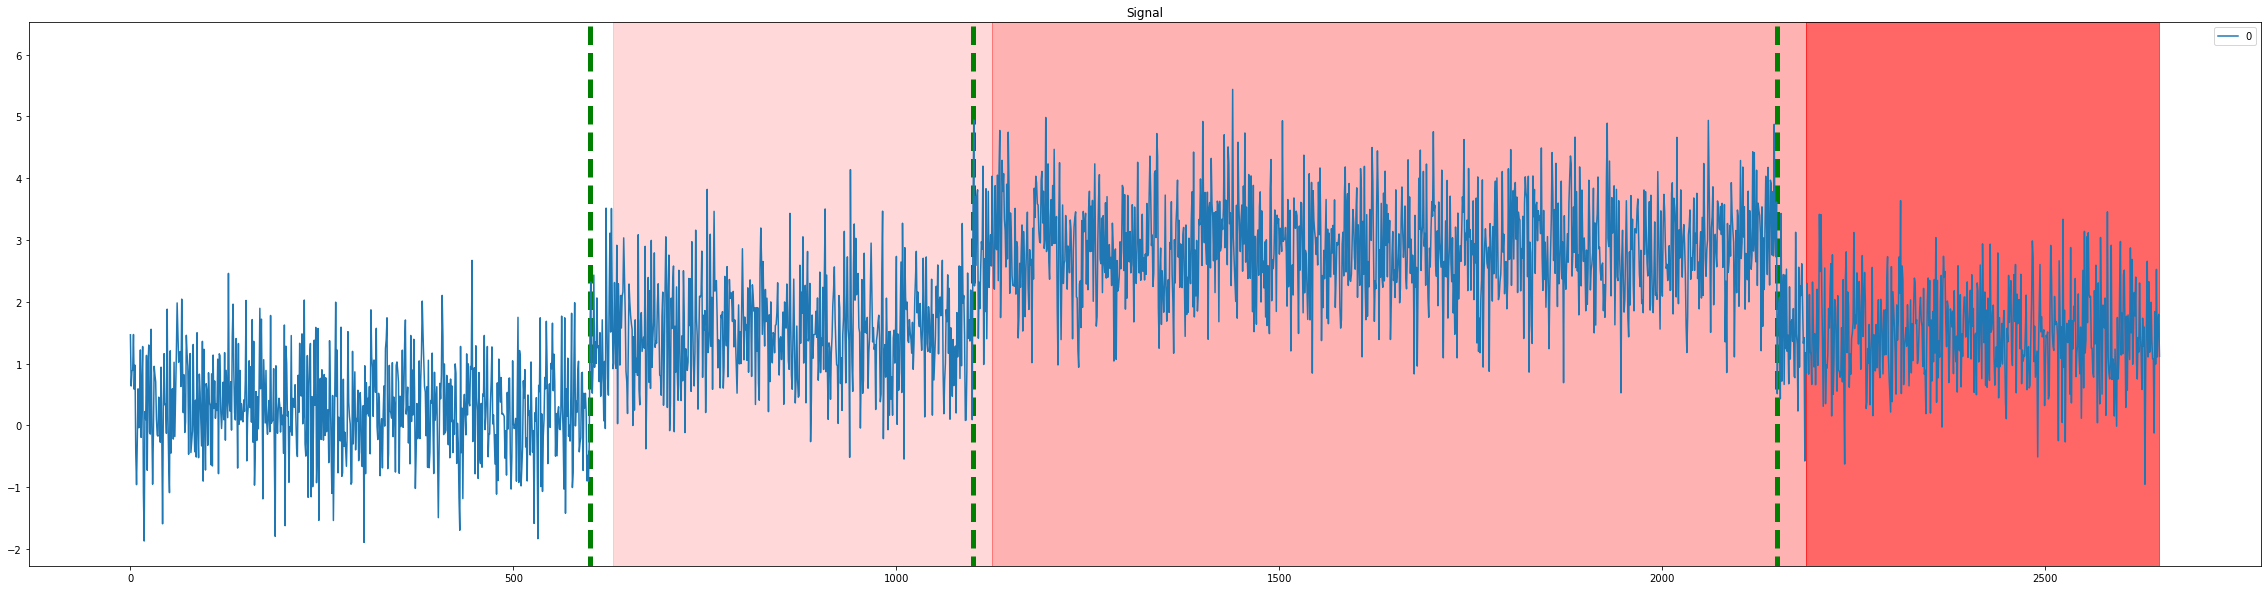

In [6]:
plot_total_df(
    data_df_synthetic, 
    "Signal", 
    changes=changes_pred_synthetic,
    gt_changes=changes_gt_synthetic,
    max_intensity=0.6,
)

Right out of the box we've managed to obtain a recall of 1.0, as can be confirmed in the plot, however the precision seems to be a little off. Overall we can say we're satisfied with the recall.

## Cavitation dataset

Let us now try to run the approach on a real world dataset:

In [7]:
path_prefix = "/home/alexpod/uni/magistrale_ai/secondo_anno/project_works/machine_learning/project/"  # data-raw path
train_path = os.path.join(path_prefix, "data-raw/DS1/")  # training files directory
test_path = os.path.join(path_prefix, "data-raw/DS2/")  # testing files directory

For efficiency reasons, we will assume that the dataset has already been prepared for us to load, thus the "Prepare data" section will be skipped.

In [8]:
LOAD_DATA = True

### Prepare data

In [9]:
if not LOAD_DATA:
    df_train = load_cavitation_data(train_path, {
        "OK": ["OK1", "OK2", "OK3", "OK4"],
        "IN": ["IN1"],
        "STANDING": ["STANDING1", "STANDING2"]
    }, verbose=1)

In [10]:
if not LOAD_DATA:
    print("There are {} samples in the dataframe".format(len(df_train)))

In [11]:
if not LOAD_DATA:
    df_train.head()

We can observe that the time field in our dataframe refers to a single sampling time unit.

In particular we have 75000 samples per time unit that we would like to squeeze down to a single value:

In [12]:
if not LOAD_DATA:
    statistical_features_train = get_cavitation_features(df_train)

In [13]:
if not LOAD_DATA:
    df_test = load_cavitation_data(test_path, {
        "OK": ["OK1"],
        "IN": ["IN1"],
        "STANDING": ["STANDING1", "STANDING2", "STANDING3", "STANDING4"]
    }, verbose=1)

    statistical_features_test = get_cavitation_features(df_test)

In [14]:
# To avoid recomputing features all over
import pickle

if LOAD_DATA:
    with open('data/cavitation/statistical_features_train.pkl', 'rb') as handle:
        statistical_features_train = pickle.load(handle)
        
    with open('data/cavitation/statistical_features_test.pkl', 'rb') as handle:
        statistical_features_test = pickle.load(handle)
        
"""
#with open('statistical_features_train.pkl', 'wb') as handle:
#    pickle.dump(statistical_features_train, handle)

#with open('statistical_features_train.pkl', 'rb') as handle:
#    unserialized_data = pickle.load(handle)

#with open('statistical_features_test.pkl', 'wb') as handle:
#    pickle.dump(statistical_features_test, handle)

#with open('statistical_features_test.pkl', 'rb') as handle:
#    unserialized_data = pickle.load(handle)
"""

"\n#with open('statistical_features_train.pkl', 'wb') as handle:\n#    pickle.dump(statistical_features_train, handle)\n\n#with open('statistical_features_train.pkl', 'rb') as handle:\n#    unserialized_data = pickle.load(handle)\n\n#with open('statistical_features_test.pkl', 'wb') as handle:\n#    pickle.dump(statistical_features_test, handle)\n\n#with open('statistical_features_test.pkl', 'rb') as handle:\n#    unserialized_data = pickle.load(handle)\n"

We've extracted four types of statistical features (single value from 75000 samples) per time unit: mean, std, skewness, kurtosis

In [15]:
statistical_features_train["mean"]

P1_x      P1_y      P1_z      P2_x      P2_y  \
time                                                                        
2013-01-10 08:28:35.281 -0.018477 -0.007019  0.001150  0.046848  0.031780   
2013-01-10 08:28:38.281 -0.018573 -0.007016  0.000854  0.046712  0.031624   
2013-01-10 08:28:41.281 -0.018778 -0.007387  0.004449  0.046011  0.031195   
2013-01-10 08:28:44.281 -0.018884 -0.007908  0.004151  0.045750  0.031047   
2013-01-10 08:28:47.281 -0.019134 -0.008219  0.003734  0.045211  0.030805   
...                           ...       ...       ...       ...       ...   
2013-01-10 09:24:44.437 -0.041707 -0.040574 -0.024623  0.018112  0.005666   
2013-01-10 09:24:47.437 -0.041545 -0.040016 -0.025320  0.017877  0.005230   
2013-01-10 09:24:50.437 -0.041861 -0.040351 -0.024094  0.017869  0.005464   
2013-01-10 09:24:53.437 -0.041667 -0.040145 -0.023876  0.018251  0.005182   
2013-01-10 09:24:56.437 -0.041792 -0.040631 -0.023281  0.017956  0.004816   

                             P2_z  stream_idx  status  
time                                                   
2013-01-10 08:28:35.281  0.050179           0       0  
2013-01-10 08:28:38.281  0.049469           0       0  
2013-01-10 08:28:41.281  0.047970           0       0  
2013-01-10 08:28:44.281  0.046726           0       0  
2013-01-10 08:28:47.281  0.045695           0       0  
...                           ...         ...     ...  
2013-01-10 09:24:44.437 -0.002580           6       2  
2013-01-10 09:24:47.437 -0.002479           6       2  
2013-01-10 09:24:50.437 -0.002547           6       2  
2013-01-10 09:24:53.437 -0.002835           6       2  
2013-01-10 09:24:56.437 -0.003221           6       2  

[1037 rows x 8 columns]

We went from 77775000 samples to 1037, which are easier to manage

### Data visualization

Let us now visualize the series:

In [16]:
status = statistical_features_train["mean"]["stream_idx"]
# get indices of timeseries where there's a change of status
changes_gt = np.where(np.roll(status, 1)!=status)[0][1:]

In [17]:
visualize_columns = ["P1_x", "P1_y", "P1_z", "P2_x", "P2_y", "P2_z"]

Changes in stream distribution occurred at:
	2013-01-10 08:29:08.281000
	2013-01-10 08:33:53.296000
	2013-01-10 08:44:53.328000
	2013-01-10 08:47:53.343000
	2013-01-10 08:51:26.343000
	2013-01-10 09:03:20.375000


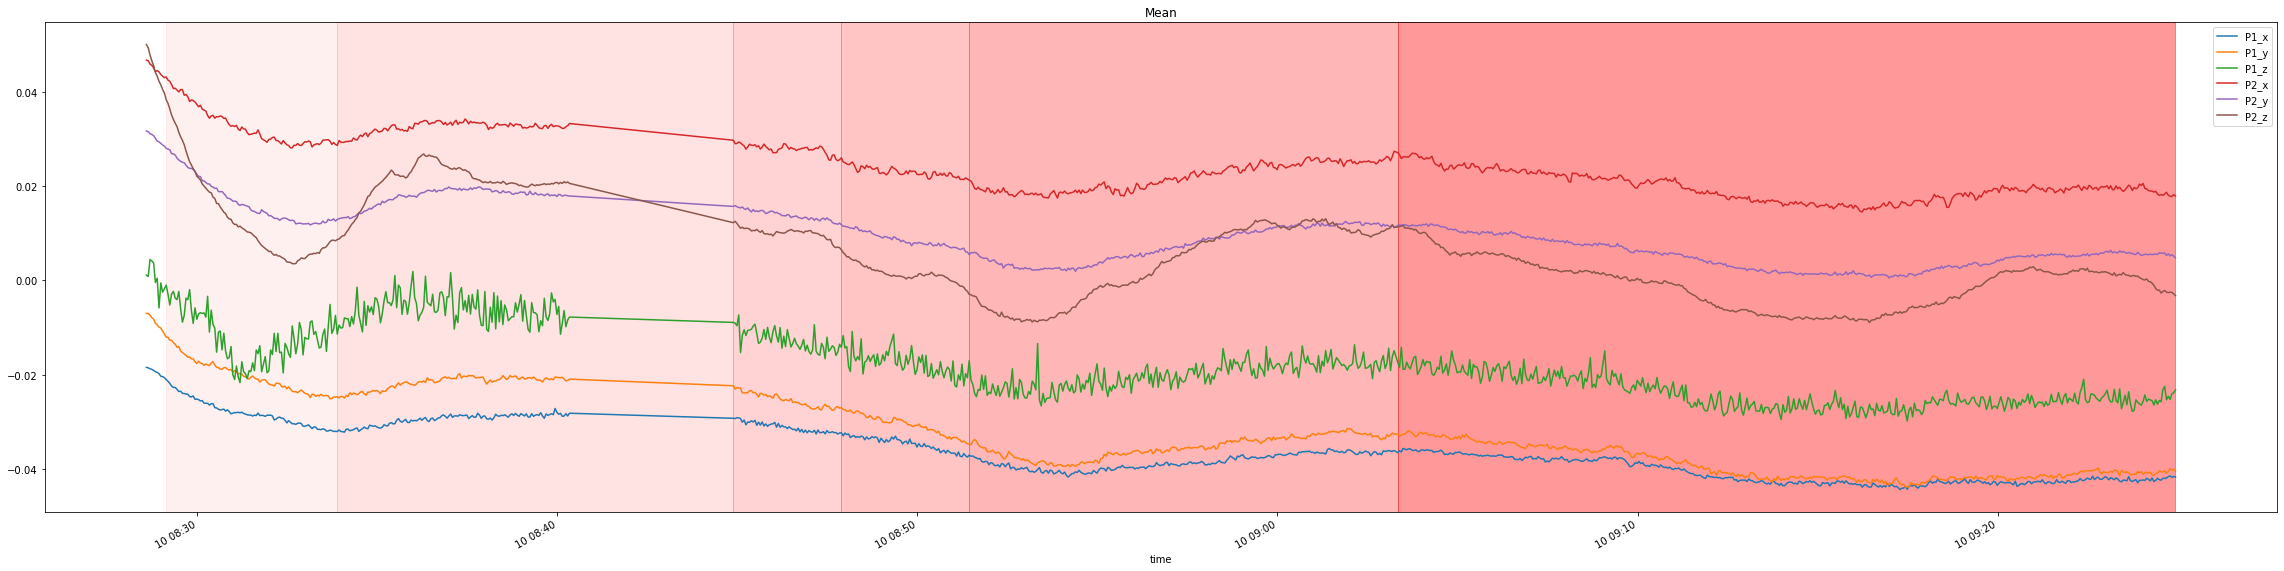

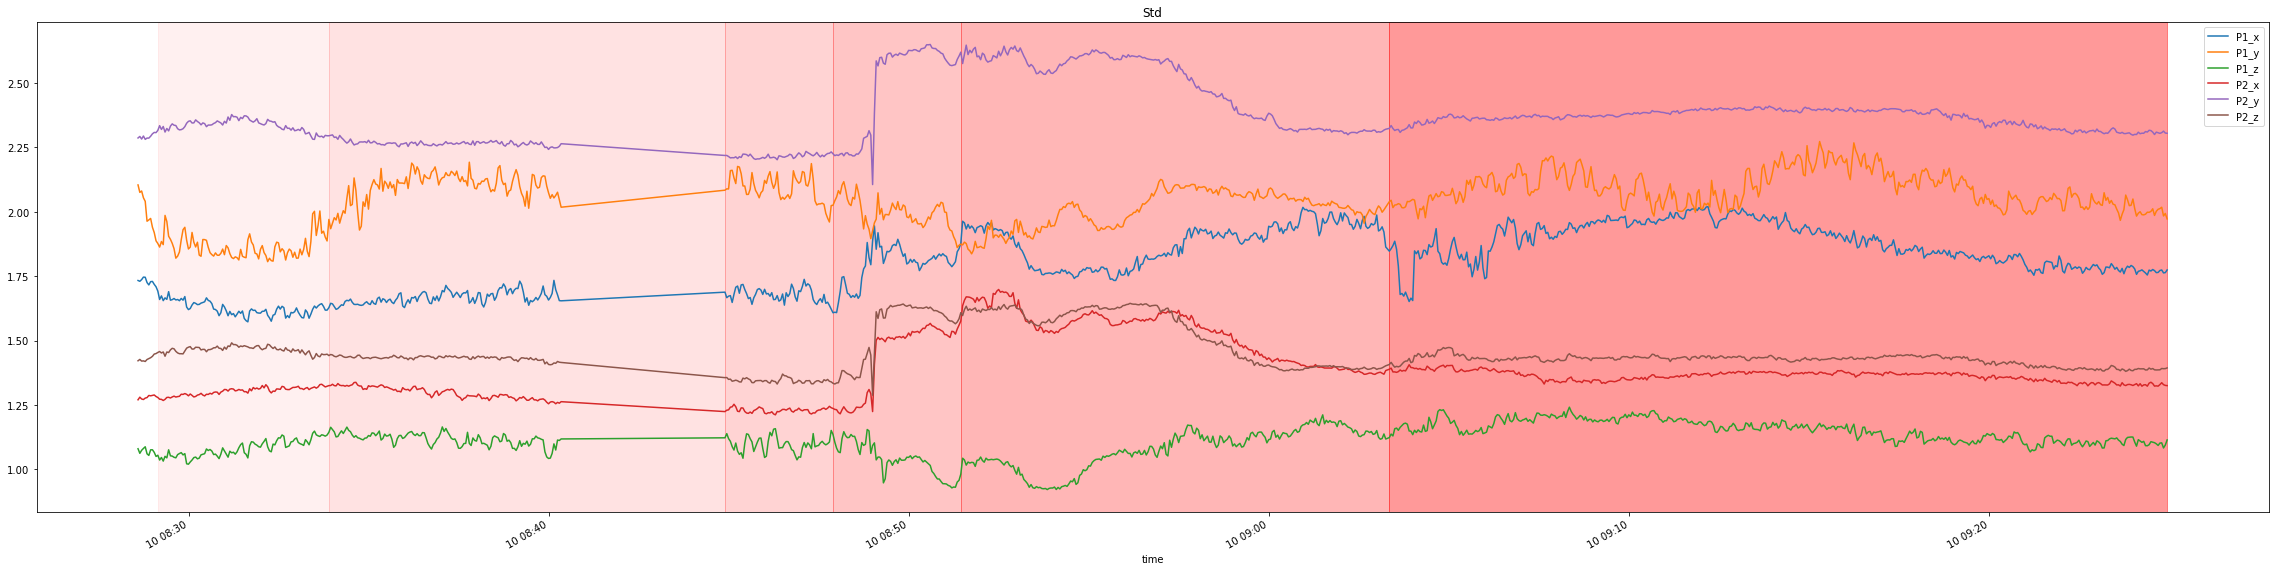

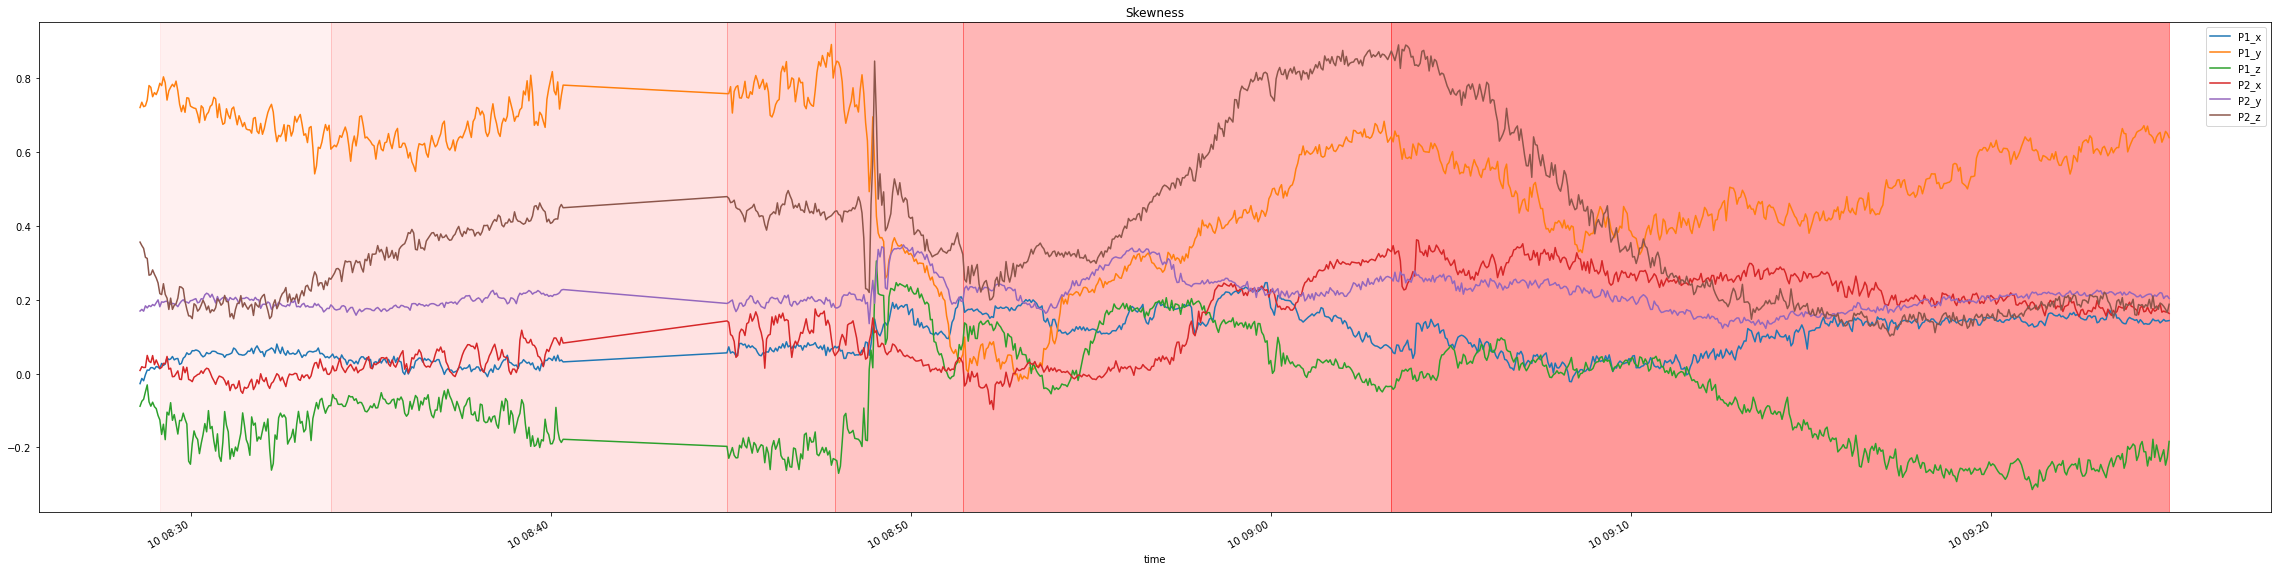

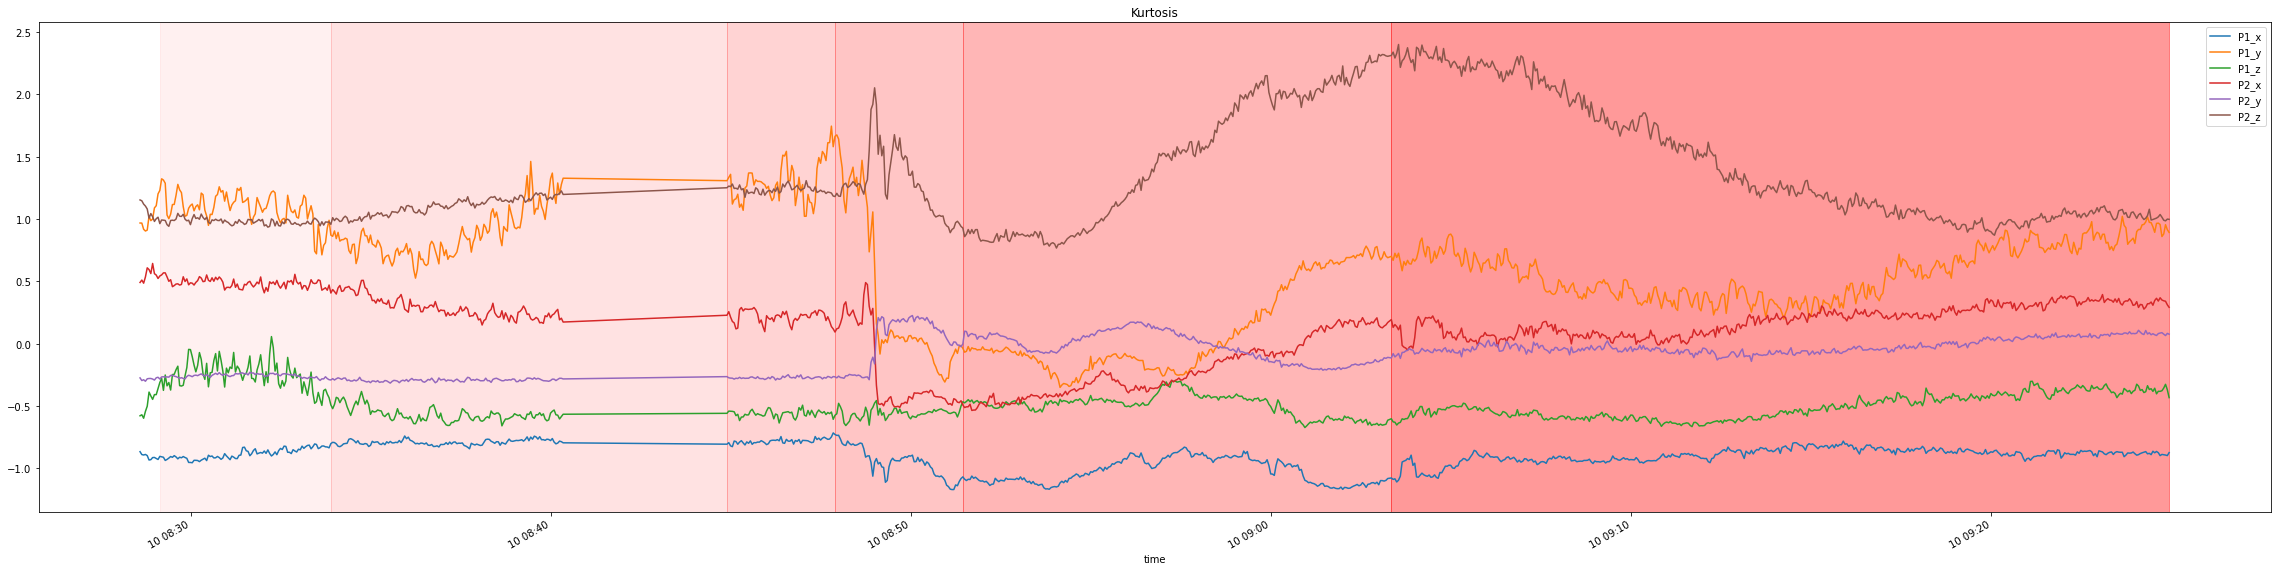

In [18]:
plot_total_df(
    statistical_features_train["mean"][visualize_columns], 
    "Mean", 
    changes=changes_gt, 
    max_intensity=0.4
)

plot_total_df(
    statistical_features_train["std"][visualize_columns], 
    "Std", 
    changes=changes_gt, 
    max_intensity=0.4,
    print_changes=False
)

plot_total_df(
    statistical_features_train["skewness"][visualize_columns], 
    "Skewness", 
    changes=changes_gt, 
    max_intensity=0.4,
    print_changes=False
)

plot_total_df(
    statistical_features_train["kurtosis"][visualize_columns], 
    "Kurtosis", 
    changes=changes_gt, 
    max_intensity=0.4,
    print_changes=False
)

We can see something different going on in highlighted zones, however we are viewing 6 series at same time.

Let us visualize an averaged signal to see if the trent will be still preserved.

In [19]:
statistical_features_averaged_train = {k: average_signal_columns(df) for (k, df) in statistical_features_train.items()}

Changes in stream distribution occurred at:
	2013-01-10 08:29:08.281000
	2013-01-10 08:33:53.296000
	2013-01-10 08:44:53.328000
	2013-01-10 08:47:53.343000
	2013-01-10 08:51:26.343000
	2013-01-10 09:03:20.375000


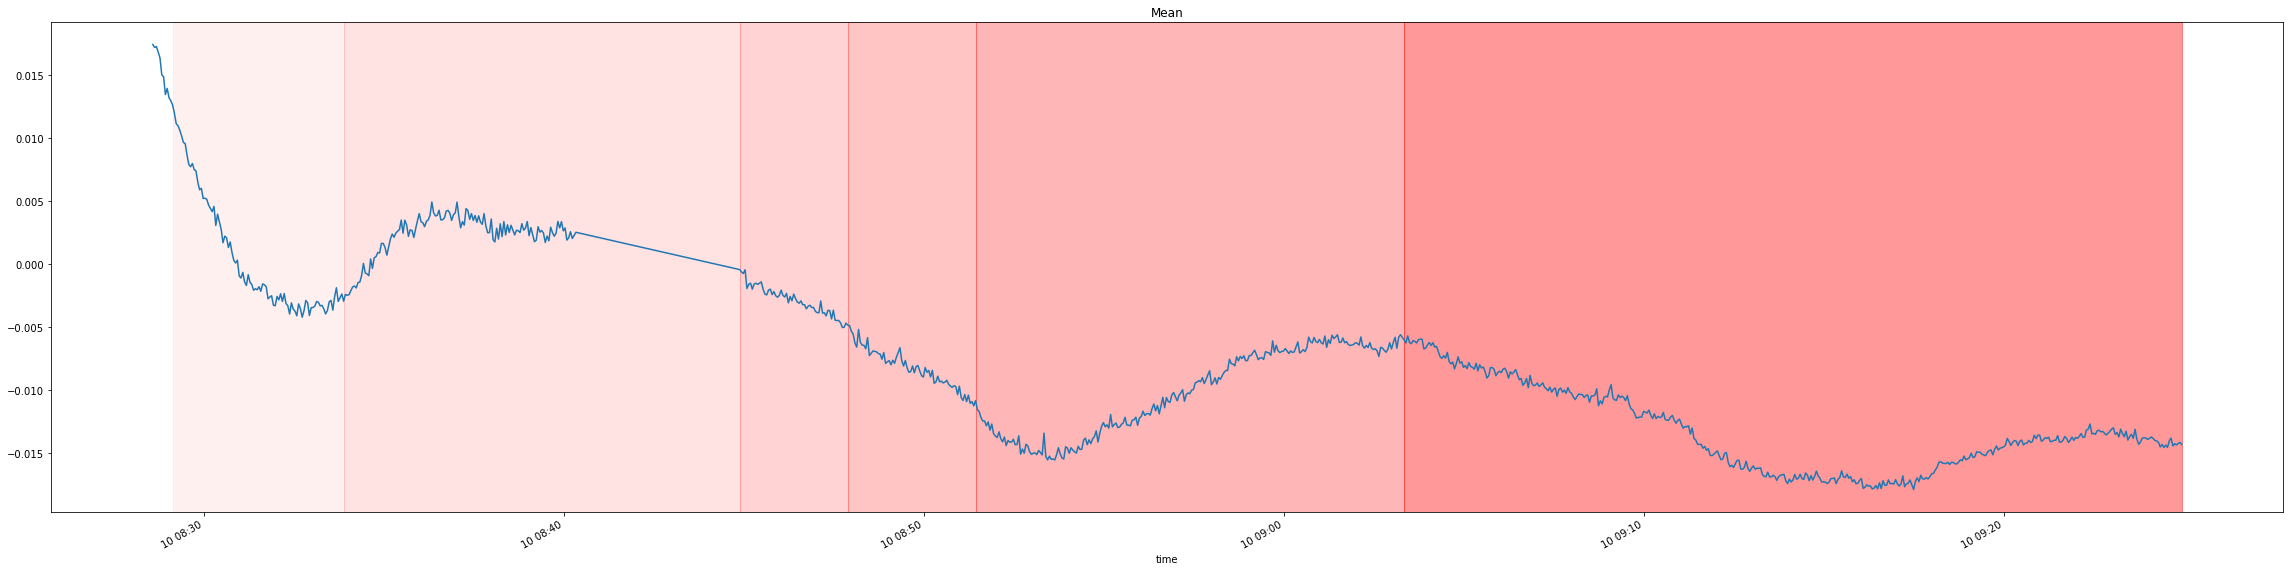

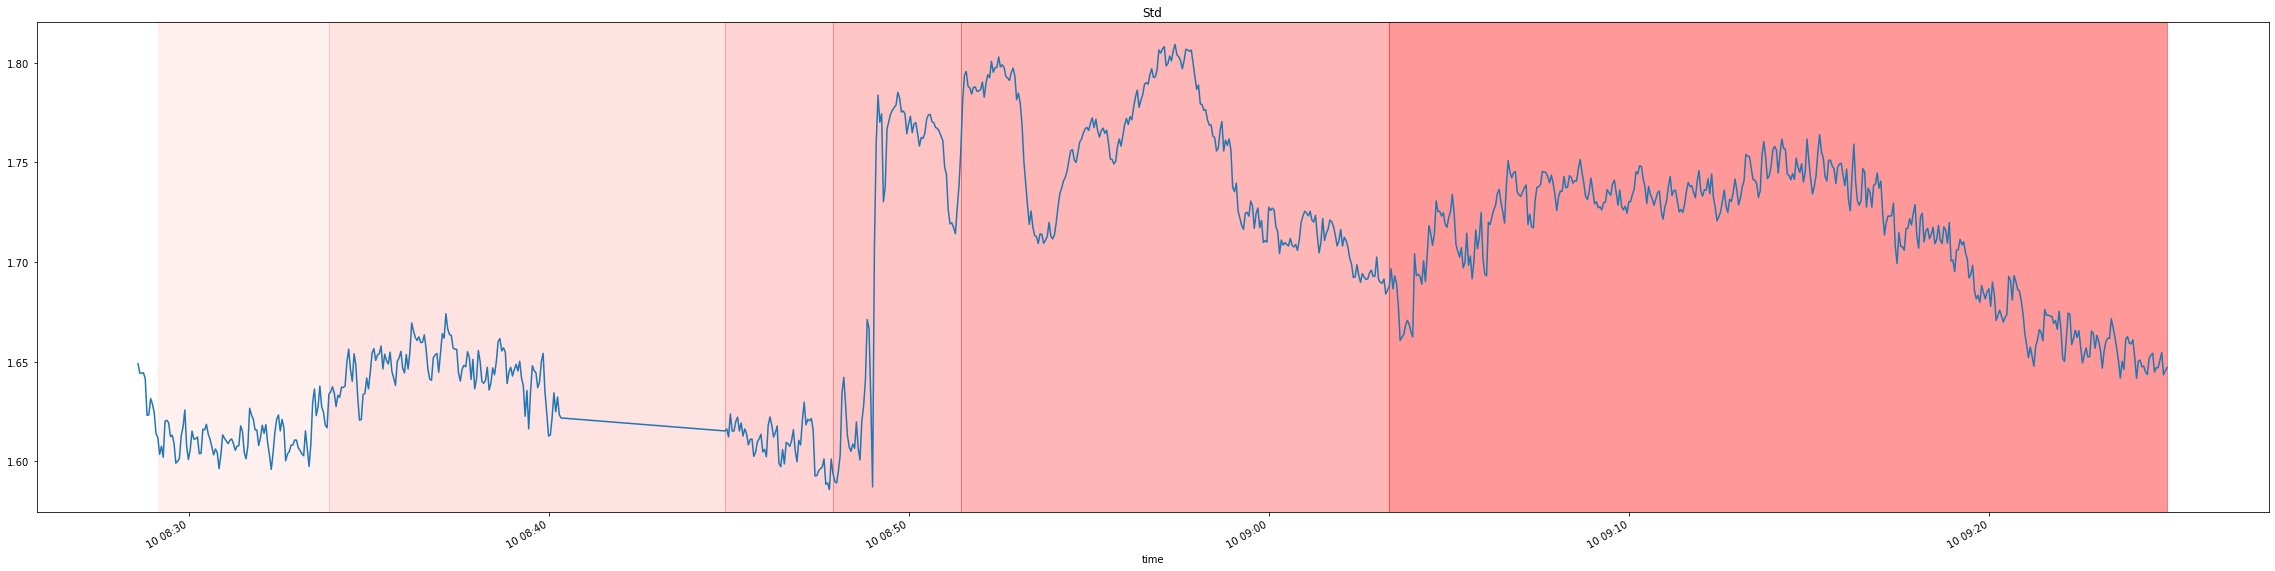

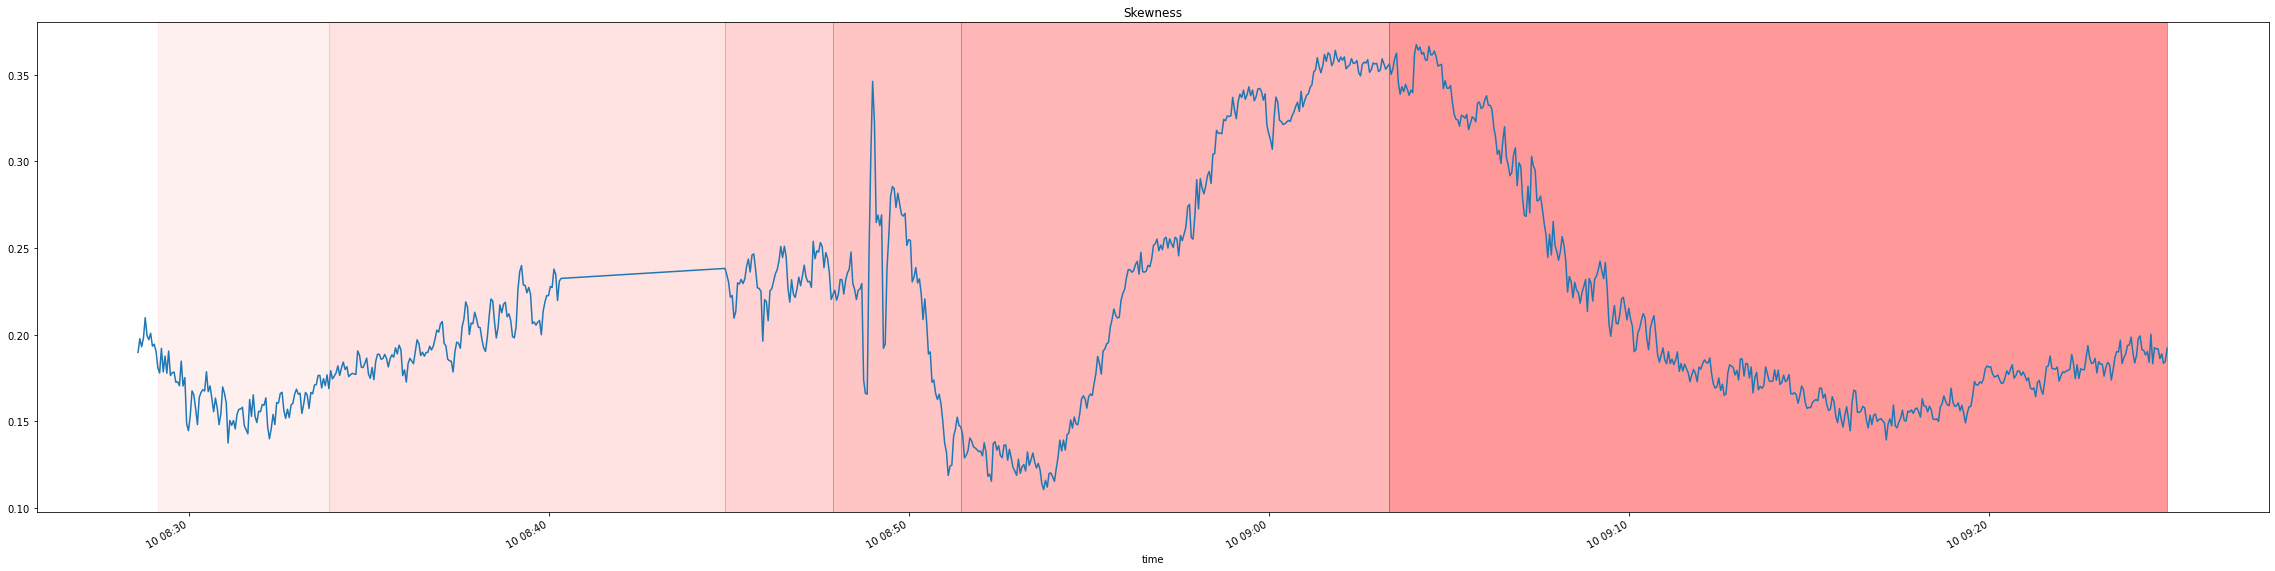

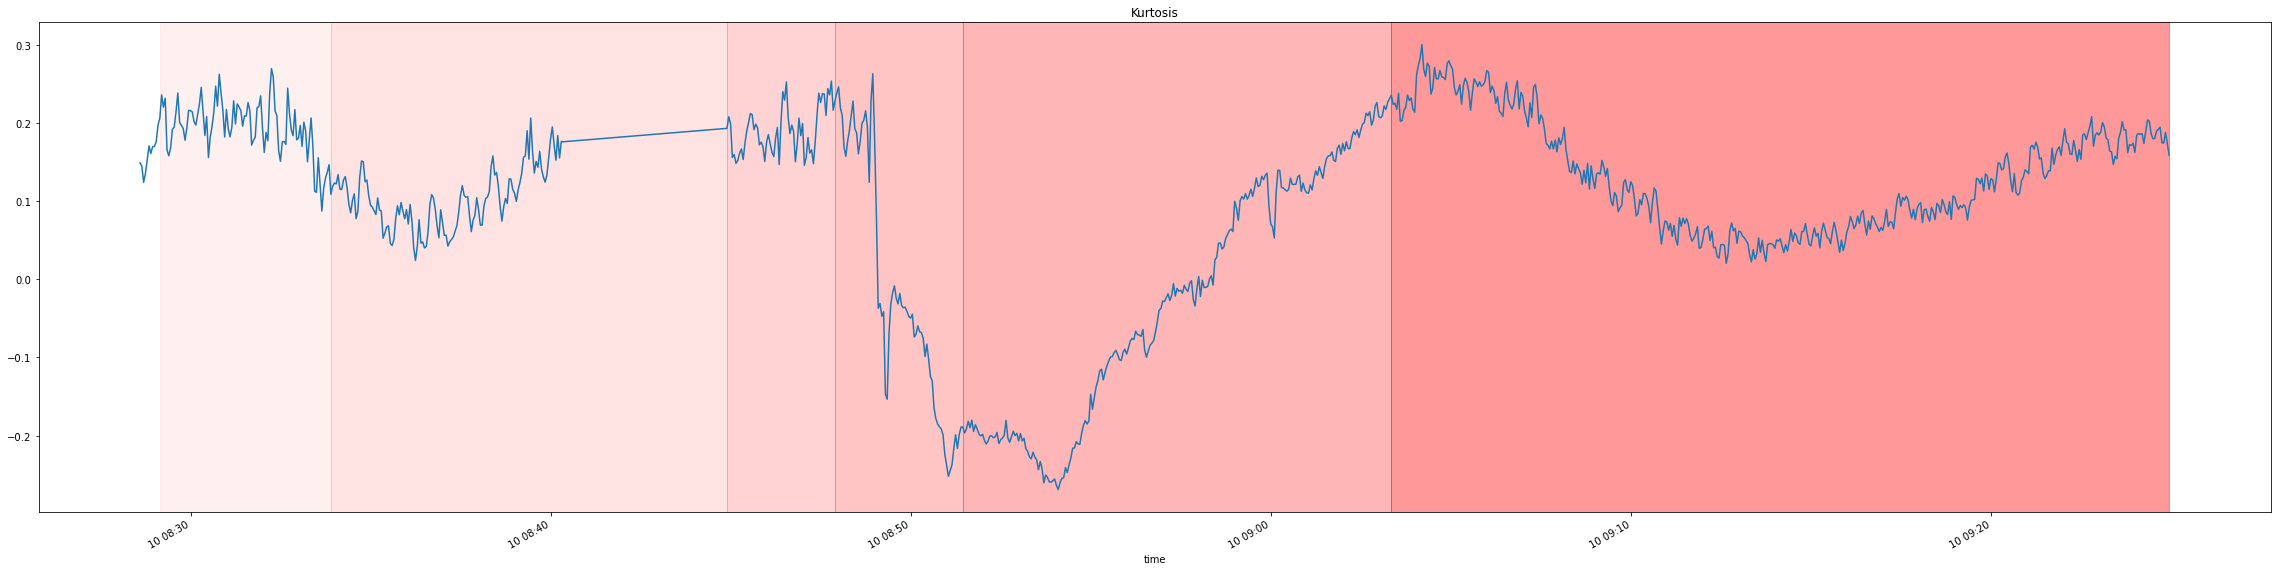

In [20]:
plot_total_df(
    statistical_features_averaged_train["mean"]["average_column"], 
    "Mean", 
    changes=changes_gt, 
    max_intensity=0.4
)

plot_total_df(
    statistical_features_averaged_train["std"]["average_column"], 
    "Std", 
    changes=changes_gt, 
    max_intensity=0.4,
    print_changes=False
)

plot_total_df(
    statistical_features_averaged_train["skewness"]["average_column"], 
    "Skewness", 
    changes=changes_gt, 
    max_intensity=0.4,
    print_changes=False
)

plot_total_df(
    statistical_features_averaged_train["kurtosis"]["average_column"], 
    "Kurtosis", 
    changes=changes_gt, 
    max_intensity=0.4,
    print_changes=False
)

We can now see that some statistical features give a more clear picture on what leads to the change of distribution

### Distribution drift detection

Let us now apply an automated technique to detect such changes of distribution

In [21]:
martingale_tester = MartingaleTest(6, epsilon=0.80)

In [22]:
series_to_use = "all_average_concat"

if series_to_use == "all_concat":
    series_np = np.concatenate((
        statistical_features_train["mean"].to_numpy()[:,:-2],
        statistical_features_train["std"].to_numpy()[:,:-2],
        statistical_features_train["skewness"].to_numpy()[:,:-2],
        statistical_features_train["kurtosis"].to_numpy()[:,:-2]
        ), axis=-1
    )
elif series_to_use == "all_average_concat":
    series_np = np.concatenate((
        statistical_features_averaged_train["mean"]["average_column"].to_numpy().reshape(-1, 1),
        statistical_features_averaged_train["std"]["average_column"].to_numpy().reshape(-1, 1),
        statistical_features_averaged_train["skewness"]["average_column"].to_numpy().reshape(-1, 1),
        statistical_features_averaged_train["kurtosis"]["average_column"].to_numpy().reshape(-1, 1),
        ), axis=-1
    )
elif series_to_use == "kurtosis":
    series_np = statistical_features_train["kurtosis"].to_numpy()[:,:-2]
elif series_to_use == "average_kurtosis":
    series_np = statistical_features_averaged_train["kurtosis"]["average_column"].to_numpy().reshape(-1, 1)

changes_pred = run_martingale_tester(
    martingale_tester,
    series_np
)

In [23]:
metrics_in_range(gt=changes_gt, pred=changes_pred, interval=10)

{'precision': 0.20833333333333334,
 'recall': 0.8333333333333334,
 'F1': 0.33333333333333337}

Despite having a high recall, we observe a low precision, this comes from the fact that the algorithm might be very sensitive to distribution changes, generating a high number of false alarms.

Let us see if we can find a combination of tester parameters that can give better results in terms of precision and F1.

In [24]:
# grid search
epsilon = [0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
M = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
# interval window inside which we consider a predicted change to hold true
# note that 1 unit of interval corresponds to 3 seconds of real time.
interval = 20
best_params, out_lists = martingale_tester_grid_search(series_np, changes_gt, epsilon, M, interval, verbose=0)

In [25]:
plot_df = pd.DataFrame(data={
    "Precision": out_lists[0], 
    "Recall": out_lists[1], 
    "epsilon": out_lists[2], 
    "M": out_lists[3],
    "F1": out_lists[4]
})
plot_precision_recall_curve(plot_df)

From the plot we can see what are our trade-off options between precision and recall.

It's not a surprise that we can trade some recall for more precision. This is generally what the grid search finds as best set of parameters.

In [26]:
best_params

{'F1': 0.5263157894736842,
 'params': (0.89, 20),
 'recall': 0.8333333333333334,
 'precision': 0.38461538461538464}

In [27]:
best_martingale_tester = MartingaleTest(best_params["params"][1], epsilon=best_params["params"][0])

In [28]:
changes_pred = run_martingale_tester(
    best_martingale_tester,
    series_np
)

Changes in stream distribution occurred at:
	2013-01-10 08:34:23.296000
	2013-01-10 08:39:29.312000
	2013-01-10 08:48:02.343000
	2013-01-10 08:50:59.343000
	2013-01-10 08:55:11.359000
	2013-01-10 08:56:56.359000
	2013-01-10 08:58:38.375000
	2013-01-10 09:02:14.375000
	2013-01-10 09:04:08.375000
	2013-01-10 09:07:08.390000
	2013-01-10 09:10:11.406000
	2013-01-10 09:17:41.421000
	2013-01-10 09:20:17.421000


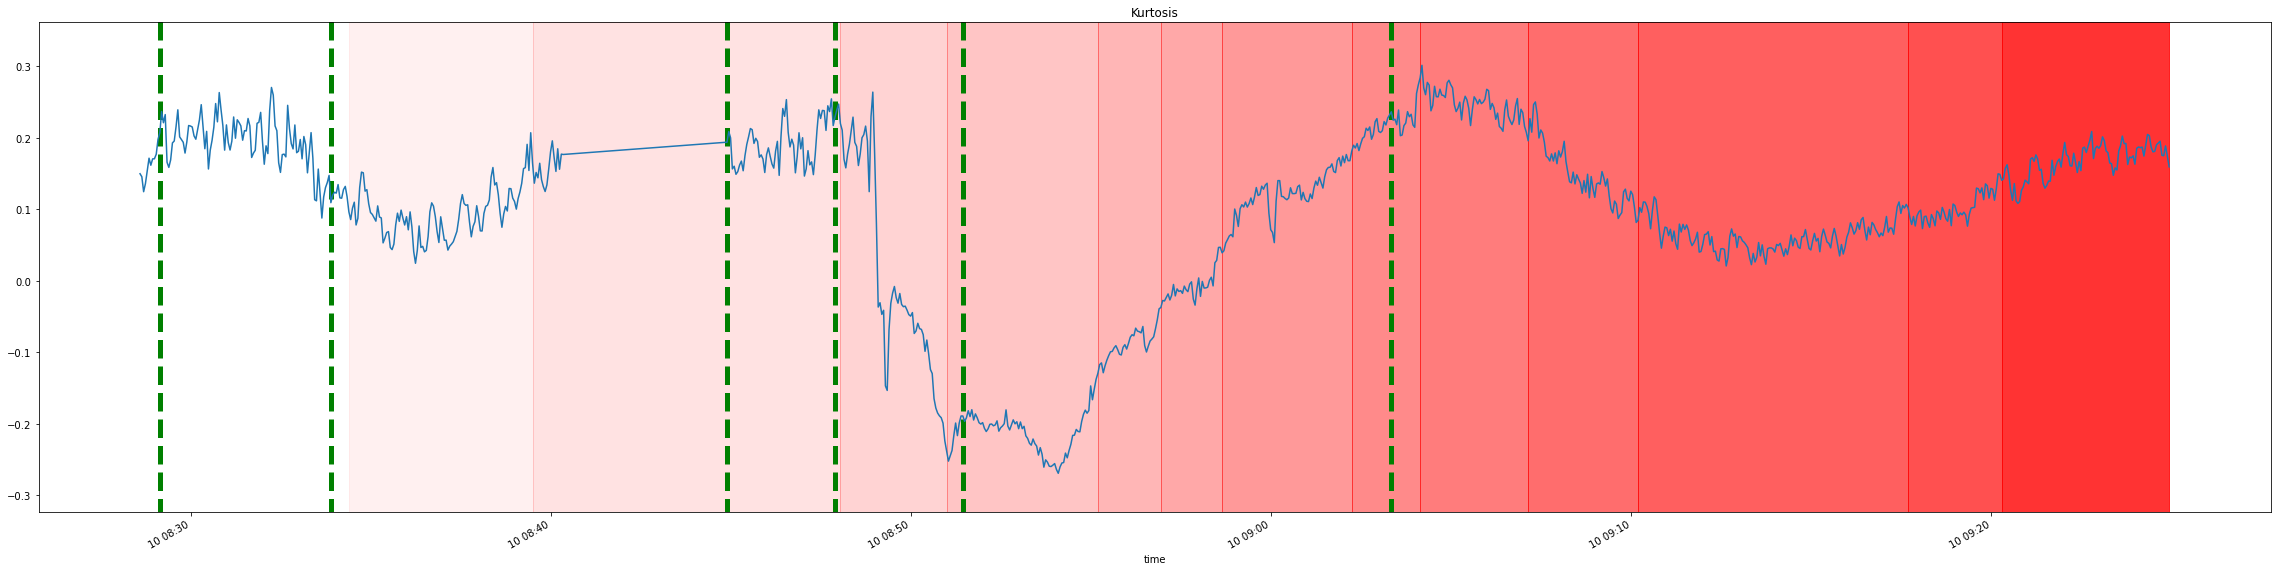

Changes in stream distribution occurred at:
	2013-01-10 08:29:08.281000
	2013-01-10 08:33:53.296000
	2013-01-10 08:44:53.328000
	2013-01-10 08:47:53.343000
	2013-01-10 08:51:26.343000
	2013-01-10 09:03:20.375000


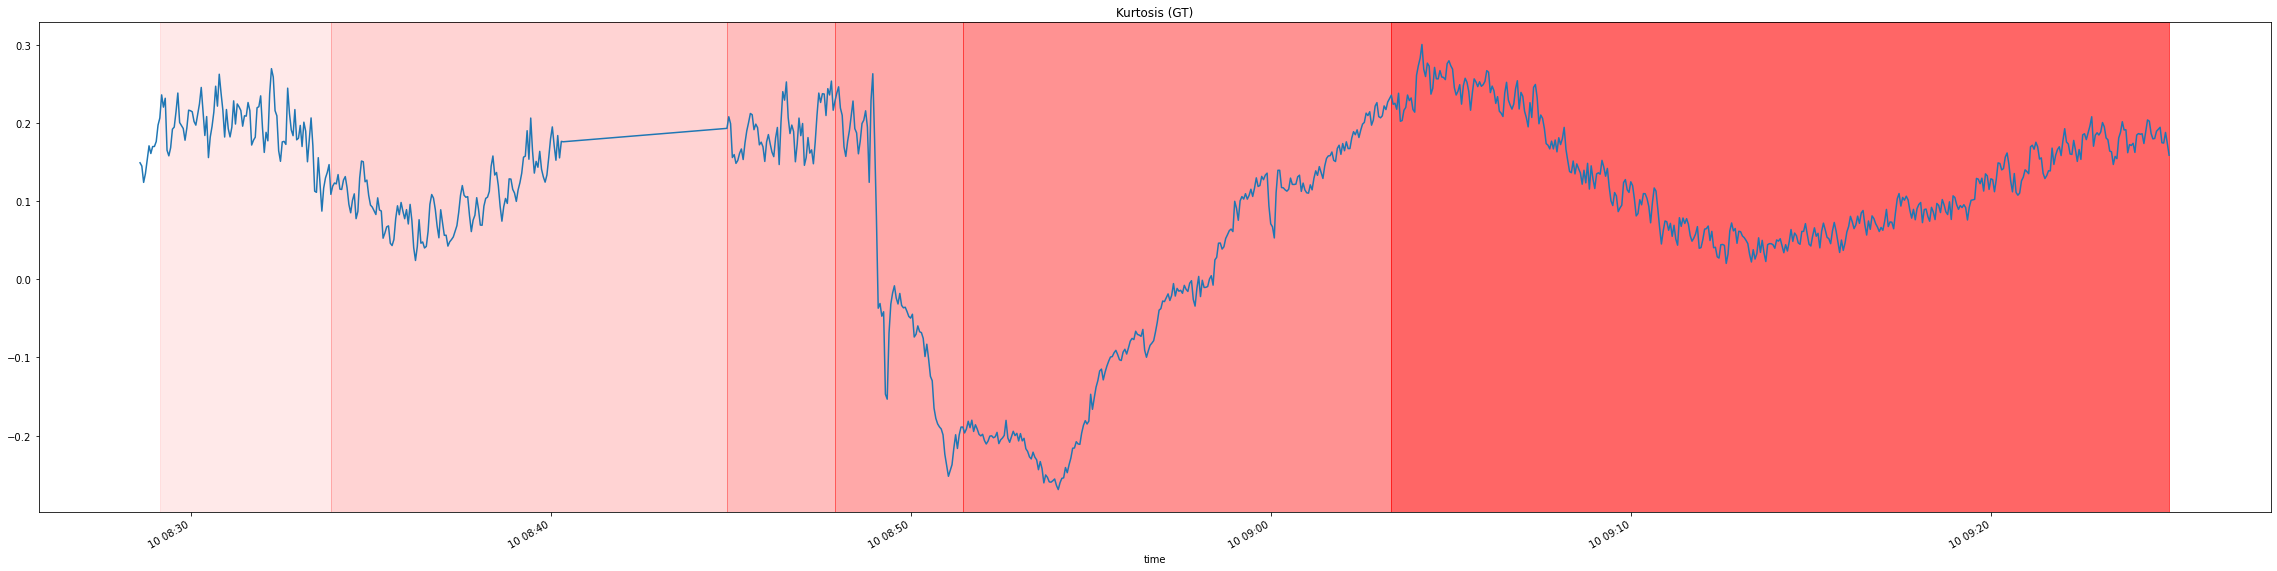

In [40]:
changes_gt_indexes = statistical_features_averaged_train["kurtosis"]["average_column"].index[changes_gt]

plot_total_df(
    statistical_features_averaged_train["kurtosis"]["average_column"], 
    "Kurtosis", 
    changes=changes_pred,
    gt_changes=changes_gt_indexes,
    max_intensity=0.8
)

plot_total_df(
    statistical_features_averaged_train["kurtosis"]["average_column"], 
    "Kurtosis (GT)", 
    changes=changes_gt, 
    max_intensity=0.6
)

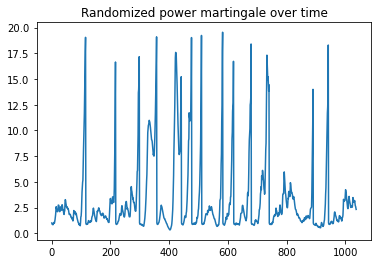

In [31]:
plt.plot(best_martingale_tester.M)
plt.title("Randomized power martingale over time")
plt.show()

## Conclusions

- The Martingale Tester algorithm is a very simple and intuitive algorithm.


- When the distribution changes are "simple", such as in the case of synthetic data, the algorithm can perform well even out of the box.


- When the signal instead is more complicated, as observed in real world dataset section, the algorithm might have difficulties with maintaining a high precision, due to a relativly high false alarm rate, despite being ran with a more optimal set of parameters.